In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [24]:
original_dataframe = pd.read_csv('Obesity Classification.csv')

original_dataframe.head();original_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      108 non-null    int64  
 1   Age     108 non-null    int64  
 2   Gender  108 non-null    object 
 3   Height  108 non-null    int64  
 4   Weight  108 non-null    int64  
 5   BMI     108 non-null    float64
 6   Label   108 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 6.0+ KB


### *Preparing data*

In [25]:
original_dataframe['Gender'] = pd.factorize(original_dataframe['Gender'])[0]
prepared_dataframe = original_dataframe.drop(['ID', 'Label'], axis=1)

In [26]:
labels = pd.factorize(original_dataframe['Label'])[0]

y = torch.tensor(labels)

In [27]:
standard_scaler = StandardScaler()

In [28]:
scaled_data = standard_scaler.fit_transform(prepared_dataframe)

In [29]:
X = torch.tensor(scaled_data, dtype=torch.float32)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

## *Model params*

In [30]:
class CustomModel(nn.Module):
    def __init__(self, input_size, hidden_layer, hidden_layer2, output_layer):
        super(CustomModel, self).__init__()

        self.batch_norm1 = nn.BatchNorm1d(hidden_layer)
        
        self.linear1 = nn.Linear(input_size, hidden_layer)
        self.relu1 = nn.LeakyReLU(negative_slope=0.5)
        
        self.linear2 = nn.Linear(hidden_layer, hidden_layer2)
        self.relu2 = nn.LeakyReLU(negative_slope=0.5)
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_layer2) 
            
        self.linear3 = nn.Linear(hidden_layer2, output_layer)
        
        self.softmax = nn.Softmax(dim=1)

        # Инициализация весов с помощью Xavier/Glorot uniform
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.xavier_uniform_(self.linear3.weight)

    def forward(self, x):
        
        x = self.linear1(x)
        x = self.batch_norm1(x)
        x = self.relu1(x)
        
        x = self.linear2(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        
        x = self.linear3(x)
        x = self.softmax(x)
        return x


input_size = 5
hidden_layer = 200
hidden_layer2 = 100
output_layer = 4


# Создание модели
model = CustomModel(input_size, hidden_layer, hidden_layer2, output_layer)

In [31]:
batch_size = 30 
selection = torch.randint(0, x_train.shape[0], (batch_size, ))
X_train, Y_train = x_train[selection], y_train[selection]


epochs = 1000
lr = 0.1

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.2)

# Списки для хранения весов и градиентов
weights_list = []
gradients_list = []

In [32]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train)
    
    loss = criterion(outputs, Y_train)
    
    loss.backward()
    optimizer.step()
    
    selection = torch.randint(0, x_train.shape[0], (batch_size, ))
    
    # Сохранение весов и градиентов
    weights = [param.data.cpu().numpy().flatten() for param in model.parameters()]
    gradients = [param.grad.data.cpu().numpy().flatten() for param in model.parameters()]
    weights_list.append(weights)
    gradients_list.append(gradients)

 
print(f'Loss: {loss.item():.4f}')


Loss: 0.7441


In [33]:
correct = 0
uncorrect = 0
predicts = model(x_test)

for i in range(len(predicts)):
    if predicts[i].argmax() == y_test[i].item():
        correct += 1
    else:
        uncorrect += 1

total = correct + uncorrect
print(f'Total {total}')
print(f'Corect {(correct / total):.2f}%')
print(f'Uncorrect {(uncorrect / total):.2f}%')

Total 33
Corect 0.76%
Uncorrect 0.24%


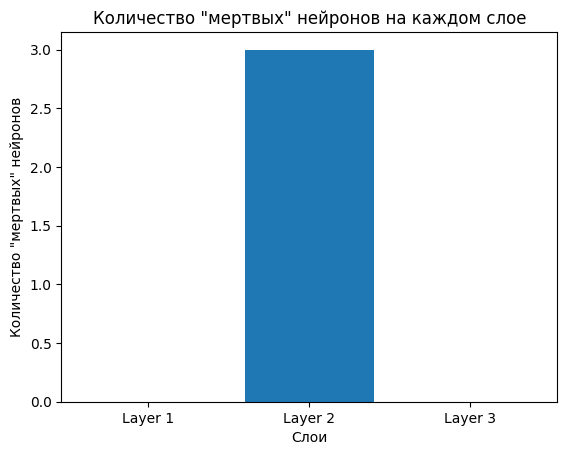

In [22]:
# Подсчет количества "мертвых" нейронов
def count_dead_neurons(model):
    dead_neurons = []

    for layer in model.children():
        if isinstance(layer, torch.nn.Linear) or isinstance(layer, torch.nn.Conv2d):
            dead_count = (layer.weight.data.abs() < 1e-5).sum().item()
            dead_neurons.append(dead_count)

    return dead_neurons

dead_neurons = count_dead_neurons(model)

# Создание гистограммы
plt.bar(range(len(dead_neurons)), dead_neurons)
plt.xlabel('Слои')
plt.ylabel('Количество "мертвых" нейронов')
plt.title('Количество "мертвых" нейронов на каждом слое')
plt.xticks(range(len(dead_neurons)), [f'Layer {i+1}' for i in range(len(dead_neurons))])
plt.show()

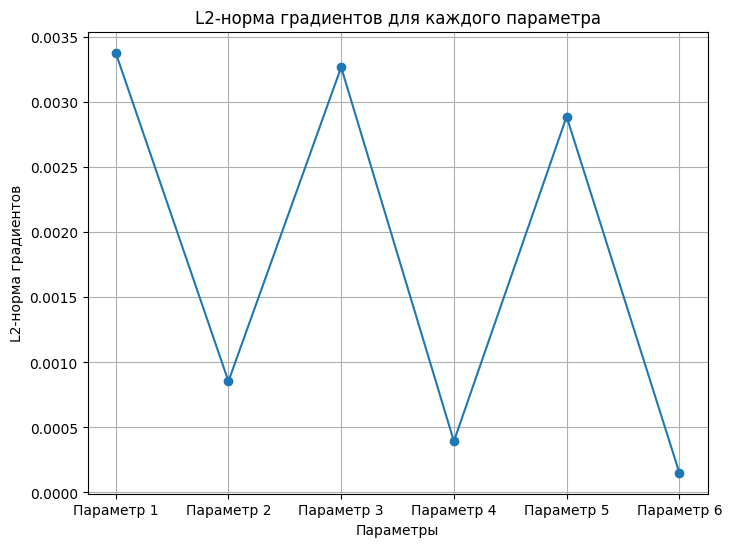

In [137]:
grads = [param.grad.norm(2).item() for param in model.parameters()]

# Создание графика
plt.figure(figsize=(8, 6))
plt.plot(grads, marker='o')
plt.xlabel('Параметры')
plt.ylabel('L2-норма градиентов')
plt.title('L2-норма градиентов для каждого параметра')
plt.xticks(range(len(grads)), [f'Параметр {i+1}' for i in range(len(grads))])
plt.grid()
plt.show()

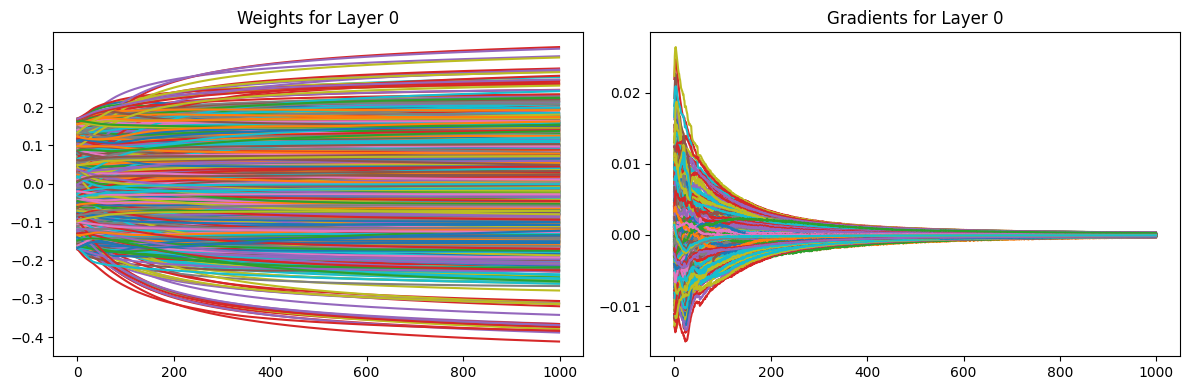

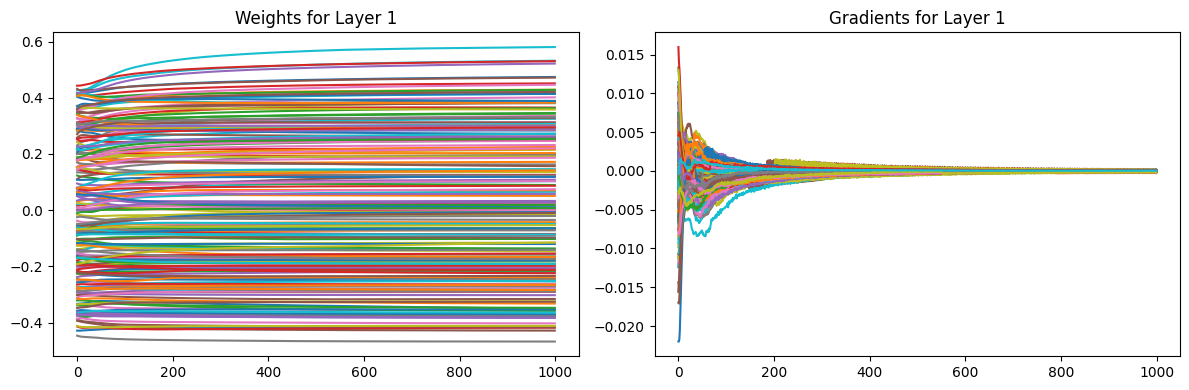

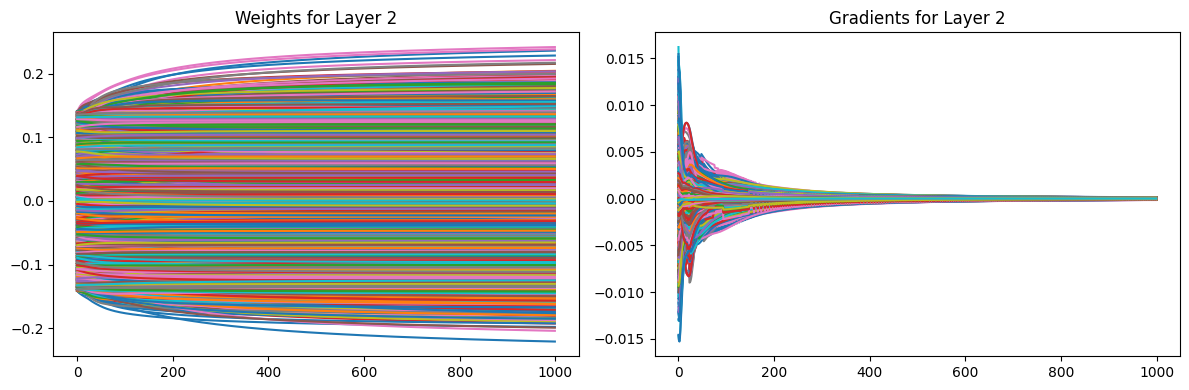

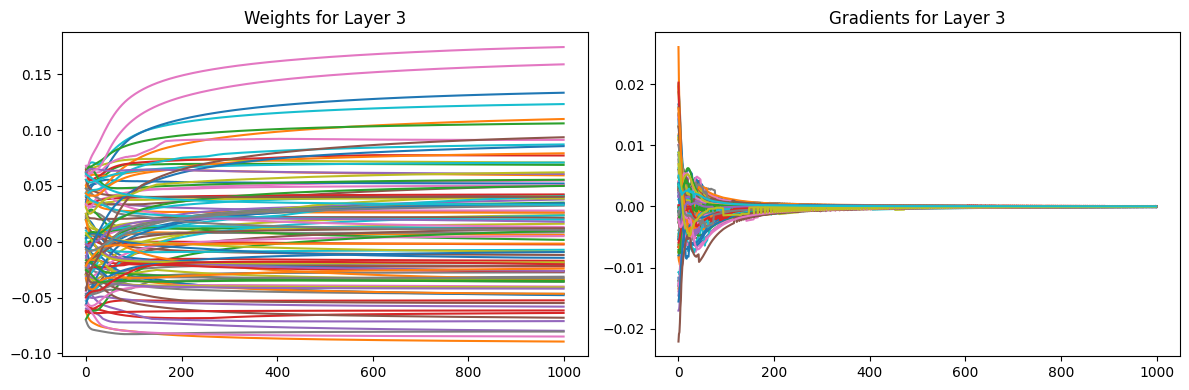

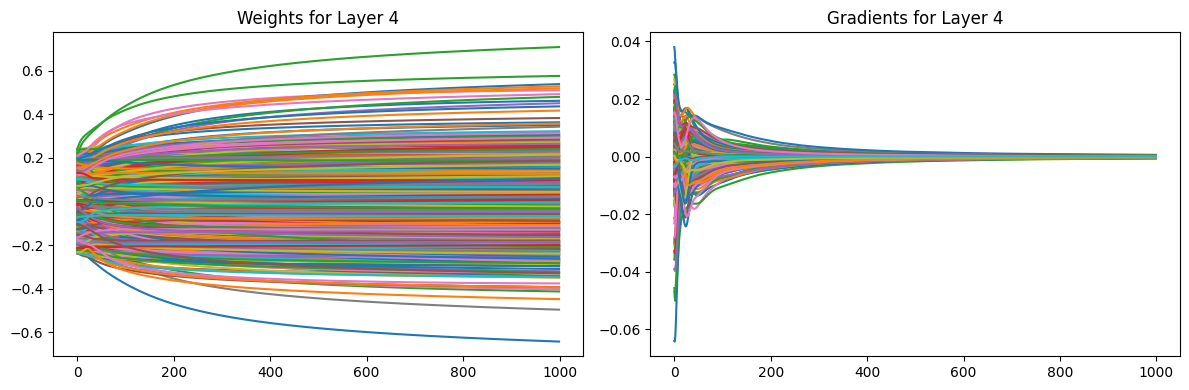

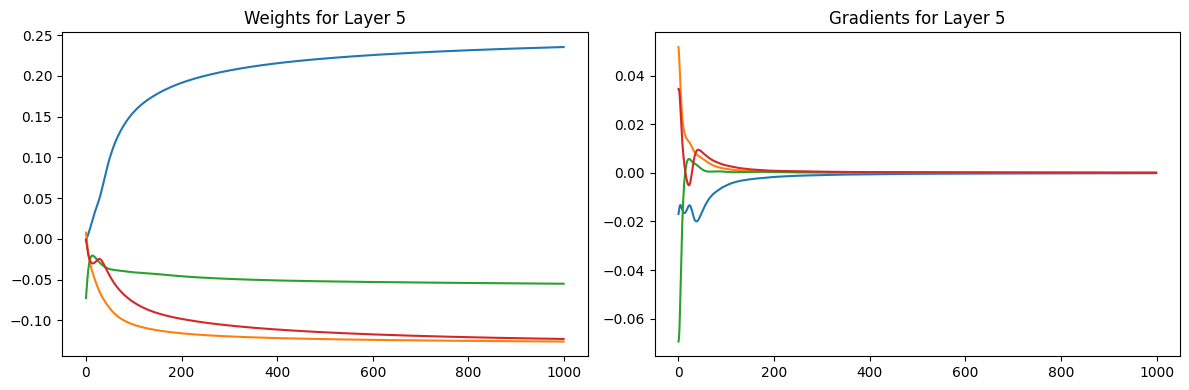

In [138]:
# Создание графиков весов и градиентов
for layer in range(len(weights_list[0])):
    layer_weights = [weights[layer] for weights in weights_list]
    layer_gradients = [gradients[layer] for gradients in gradients_list]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(layer_weights)
    plt.title(f'Weights for Layer {layer}')

    plt.subplot(1, 2, 2)
    plt.plot(layer_gradients)
    plt.title(f'Gradients for Layer {layer}')

    plt.tight_layout()
    plt.show()